<h1><center>Thinkful Bootcamp 4.4.5: Build your own NLP model</h1>

For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

Write up your report in a Jupyter notebook. Be sure to explicitly justify the choices you make throughout, and submit it below.

## Data Processing

#### Download data

The Reuters-21578 data set from nltk will be used in this exercise. It includes about 10k news articles, all assigned to relevant categories. Some articles are assigned to more than one category.

In [1]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\yfsta\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

#### Load data

In order to avoid later performance issues, a random set of 4000 articles will be used rather than the entire 10+k article corpus.

In [2]:
from nltk.corpus import reuters, stopwords
import random

doc_list0 = reuters.fileids();
doc_list = random.choices(doc_list0, k=4000)
training_set = [ d.startswith("train") for d in doc_list ]
test_set = [ d.startswith("test") for d in doc_list ]

Separate documents and categories using pre-defined training/test sets

In [3]:
documents = [ reuters.raw(doc_id) for doc_id in doc_list ]

In [4]:
categories = [ reuters.categories(doc_id) for doc_id in doc_list ]

#### Data cleaning

Separate grouped words: While these may hold value as pairs, they will probably match better if analyzed independently.

In [5]:
import re

cleaned_docs = [ re.sub('[-/&]',' ',doc) for doc in documents ]

Change 'U.S.' to 'USA' to avoid confusion with 'us.' This should not be an issue for most acronyms.

In [6]:
cleaned_docs = [ re.sub(' U.S. ',' USA ',doc) for doc in cleaned_docs ]
cleaned_docs = [ re.sub(' US ',' USA ',doc) for doc in cleaned_docs ]

Remove possessives: These are probably better grouped with their base.

In [7]:
cleaned_docs = [ re.sub('\'s','',doc) for doc in cleaned_docs ]

Remove punctuation: Sentence analysis will not be used in this study.

In [8]:
cleaned_docs = [ re.sub('[^\w\s]','',doc) for doc in cleaned_docs ]

Remove numbers: There is too many factors that could contribute to variation. Spelled out numbers are left as they can still be useful in terms of denoting scale.

In [9]:
cleaned_docs = [ re.sub('[0-9]','',doc) for doc in cleaned_docs ]

Remove new lines and extra white spaces

In [10]:
cleaned_docs = [ ' '.join(re.sub('\n','',doc).split()) for doc in cleaned_docs ]

Convert everything to lowercase to avoid separating words due to capitalization.

In [11]:
cleaned_docs = [ doc.lower() for doc in cleaned_docs ]

#### Parse language

Create word count map

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
word_map = count_vectorizer.fit_transform(cleaned_docs)

Create article category map

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

category_mlb = MultiLabelBinarizer(classes=reuters.categories())
category_map = category_mlb.fit_transform(categories)

## Feature Generation

#### Bag of Words

In [14]:
word_list = count_vectorizer.get_feature_names()

In [15]:
import numpy as np

total_word_freq = word_map.toarray().sum(axis=0)

In [16]:
import pandas as pd

word_freq = pd.DataFrame()
word_freq['word'] = word_list
word_freq['freq'] = total_word_freq

In [17]:
most_freq_words = word_freq[word_freq['freq'].rank(ascending=False,method='min') <= 1000]

Convert to a sparse matrix to improve performance.

In [18]:
from scipy import sparse

bow_X = sparse.csr_matrix(word_map[:,most_freq_words.index])

#### tf-idf

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True, norm=u'l2', smooth_idf=True)

tfidf_X = tfidf_vectorizer.fit_transform(cleaned_docs)

## Supervised Learning Models

#### Setup

In [20]:
bow_X_train = bow_X[ np.where(training_set)[0], :]
bow_X_test = bow_X[ np.where(test_set)[0], :]

tfidf_X_train = tfidf_X[ np.where(training_set)[0], :]
tfidf_X_test = tfidf_X[ np.where(test_set)[0], :]

Y_train = category_map[ training_set, : ]
Y_test = category_map[ test_set,: ]

#### Random Forest

In [21]:
from sklearn import ensemble

bow_rfc = ensemble.RandomForestClassifier(n_estimators=100)
bow_rfc_train = bow_rfc.fit(bow_X_train, Y_train)

print('BoW Random Forest Training set score:', bow_rfc.score(bow_X_train, Y_train))
print('BoW Random Forest Test set score:', bow_rfc.score(bow_X_test, Y_test))

tfidf_rfc = ensemble.RandomForestClassifier(n_estimators=100)
tfidf_rfc_train = tfidf_rfc.fit(tfidf_X_train, Y_train)

tfidf_rfc_train_score = tfidf_rfc.score(tfidf_X_train, Y_train)
tfidf_rfc_test_score = tfidf_rfc.score(tfidf_X_test, Y_test)

print('\ntf-idf Random Forest Training set score:', tfidf_rfc_train_score)
print('tf-idf Random Forest Test set score:', tfidf_rfc_test_score)

BoW Random Forest Training set score: 0.9948114839156001
BoW Random Forest Test set score: 0.6447249774571686

tf-idf Random Forest Training set score: 0.9930819785541335
tf-idf Random Forest Test set score: 0.6501352569882777


There is a very high degree of overfitting for Random Forest for both the BoW and tf-idf data sets. While training set scores are very high, test set scores are much lower with tf-idf slightly better but still only at 0.66.

#### Linear SVM

In [22]:
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

bow_svc = LinearSVC()
bow_svc_ovr = OneVsRestClassifier(bow_svc,n_jobs=-1)
bow_svc_train = bow_svc_ovr.fit(bow_X_train, Y_train)

bow_svc_train_score = bow_svc_ovr.score(bow_X_train, Y_train)
bow_svc_test_score = bow_svc_ovr.score(bow_X_test, Y_test)

print('BoW Linear SVC Training set score:', bow_svc_train_score)
print('BoW Linear SVC Test set score:', bow_svc_test_score)

tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)
tfidf_svc_train = tfidf_svc_ovr.fit(tfidf_X_train, Y_train)

tfidf_svc_train_score = tfidf_svc_ovr.score(tfidf_X_train, Y_train)
tfidf_svc_test_score = tfidf_svc_ovr.score(tfidf_X_test, Y_test)

print('\ntf-idf Linear SVC Training set score:', tfidf_svc_train_score)
print('tf-idf Linear SVC Test set score:', tfidf_svc_test_score)

BoW Linear SVC Training set score: 0.9948114839156001
BoW Linear SVC Test set score: 0.7348963029756538

tf-idf Linear SVC Training set score: 0.9875475613974404
tf-idf Linear SVC Test set score: 0.7601442741208295


Overfitting is an issue for Linear SVC as well. Test set scores are a bit higher than for Random Forest, with BoW at 0.71 and tf-idf at 0.74.

#### Gradient Boosted

In [23]:
bow_gbc = ensemble.GradientBoostingClassifier()
bow_gbc_ovr = OneVsRestClassifier(bow_gbc,n_jobs=-1)
bow_gbc_train = bow_gbc_ovr.fit(bow_X_train, Y_train)

print('BoW Gradient Boosted Training set score:', bow_gbc_ovr.score(bow_X_train, Y_train))
print('BoW Gradient Boosted Test set score:', bow_gbc_ovr.score(bow_X_test, Y_test))

tfidf_gbc = ensemble.GradientBoostingClassifier()
tfidf_gbc_ovr = OneVsRestClassifier(tfidf_gbc,n_jobs=-1)
tfidf_gbc_train = tfidf_gbc_ovr.fit(tfidf_X_train, Y_train)

tfidf_gbc_train_score = tfidf_gbc_ovr.score(tfidf_X_train, Y_train)
tfidf_gbc_test_score = tfidf_gbc_ovr.score(tfidf_X_test, Y_test)

print('\ntf-idf Gradient Boosted Training set score:', tfidf_gbc_train_score)
print('tf-idf Gradient Boosted Test set score:', tfidf_gbc_test_score)

BoW Gradient Boosted Training set score: 0.9702525077827742
BoW Gradient Boosted Test set score: 0.6961226330027052

tf-idf Gradient Boosted Training set score: 0.9702525077827742
tf-idf Gradient Boosted Test set score: 0.690712353471596


Results for the Gradient Boosted model fall in between Random Forest and Linear SVC. Like the others, there is a high degree of overfitting.

## Cross Validation and Conclusion

#### Cross Validation

The cross_validate function calculates scores and runtimes for any given number of folds. cv=5 is used here.

In [24]:
from sklearn.model_selection import cross_validate, cross_val_score

bow_rfc_cv = cross_validate(bow_rfc_train, bow_X_train, Y_train, cv=5, n_jobs=4)
tfidf_rfc_cv = cross_validate(tfidf_rfc_train, tfidf_X_train, Y_train, cv=5, n_jobs=4)

In [28]:
bow_svc_cv = cross_validate(bow_svc_train, bow_X_train, Y_train, cv=5, n_jobs=4)
tfidf_svc_cv = cross_validate(tfidf_svc_train, tfidf_X_train, Y_train, cv=5, n_jobs=4)

In [34]:
bow_gbc_cv = cross_validate(bow_gbc_train, bow_X_train, Y_train, cv=5, n_jobs=4)
tfidf_gbc_cv = cross_validate(tfidf_gbc_train, tfidf_X_train, Y_train, cv=5, n_jobs=4)

#### Conclusion

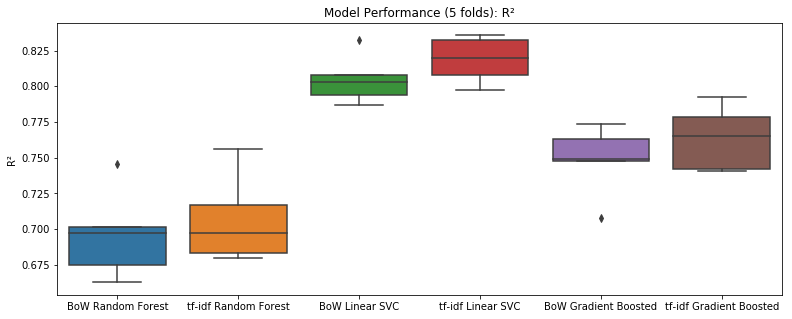

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
    
score_df = pd.DataFrame(data={
            'BoW Random Forest': bow_rfc_cv['test_score'], 'tf-idf Random Forest': tfidf_rfc_cv['test_score'],
            'BoW Linear SVC': bow_svc_cv['test_score'], 'tf-idf Linear SVC': tfidf_svc_cv['test_score'],
            'BoW Gradient Boosted': bow_gbc_cv['test_score'], 'tf-idf Gradient Boosted': tfidf_gbc_cv['test_score']})

plt.figure(figsize=(13,5))
sns.boxplot(data=score_df)
plt.title('Model Performance (5 folds): R\u00b2')
plt.ylabel('R\u00b2')
plt.show()

Linear SVC is the clear winner in terms of performance. Although the tf-idf version has a slightly wider IQR, it still falls within 0.04 and it about 0.03 higher than the BoW version.

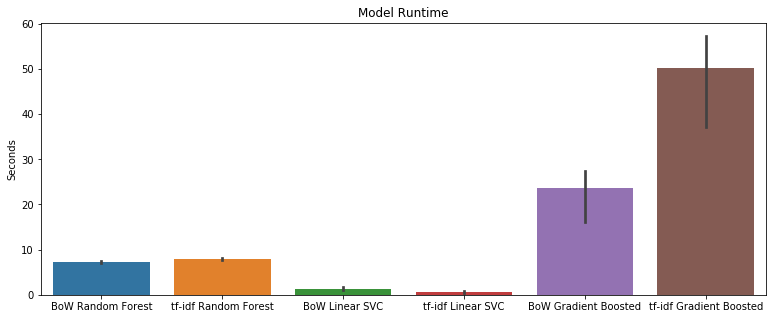

In [36]:
time_df = pd.DataFrame(data={
            'BoW Random Forest': bow_rfc_cv['fit_time'], 'tf-idf Random Forest': tfidf_rfc_cv['fit_time'],
            'BoW Linear SVC': bow_svc_cv['fit_time'], 'tf-idf Linear SVC': tfidf_svc_cv['fit_time'],
            'BoW Gradient Boosted': bow_gbc_cv['fit_time'], 'tf-idf Gradient Boosted': tfidf_gbc_cv['fit_time']})

plt.figure(figsize=(13,5))
sns.barplot(data=time_df)
plt.title('Model Runtime')
plt.ylabel('Seconds')
plt.show()

Runtime for the Linear SVC models was far less than either Random Forest or the Gradient Boosted model as well so Linear SVC will be used going forward.

## Model Improvement

The best performing (and fastest) model tested was Linear SVC using tf-idf with an average cross validation score of 0.816.

In [37]:
np.mean(tfidf_svc_cv['test_score'])

0.8187430900430883

#### Apply a grid search

In [38]:
from sklearn.model_selection import GridSearchCV

tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(tfidf_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(tfidf_X_train,Y_train)
svc_fit.best_score_

0.8398478035281909

Adjusting hyperparameters increases accuracy by about 2% but not yet to 5%.

#### Use spaCy to process documents

In [95]:
import spacy
nlp = spacy.load('en')

Create custom preprocessor and tokenizer to be used with tf-idf vectorizer

In [75]:
lemmatizer = spacy.lang.en.English()

def custom_pp(doc):
    return(doc.lower())

def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens])

In [98]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 2, ngram_range = (1,1),
                                   use_idf = True, norm = u'l2', smooth_idf = True,
                                   preprocessor = custom_pp, tokenizer = custom_tokenizer)
tfidf_X = tfidf_vectorizer.fit_transform(documents)

tfidf_X_train = tfidf_X[ np.where(training_set)[0], :]
tfidf_X_test = tfidf_X[ np.where(test_set)[0], :]

In [99]:
tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(tfidf_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(tfidf_X_train,Y_train)
svc_fit.best_score_

0.8408855067450709

Simply switching to using spaCy lemmatization has minimal effect.

In [116]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range = (1,1),
                                   use_idf=True, norm=u'l2', smooth_idf=True,
                                   preprocessor = custom_pp, tokenizer = custom_tokenizer)
tfidf_X = tfidf_vectorizer.fit_transform(documents)

tfidf_X_train = tfidf_X[ np.where(training_set)[0], :]
tfidf_X_test = tfidf_X[ np.where(test_set)[0], :]

In [117]:
tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(tfidf_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(tfidf_X_train,Y_train)
svc_fit.best_score_

0.8453822206848841

Increasing min_df to 10 improves accuracy another 0.5%. Since the original settings were focused on single sentences instead of full articles, increasing min_df seems logical.

In [124]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range = (1,1),
                                   use_idf=True, norm=u'l2', smooth_idf=True,
                                   preprocessor = custom_pp, tokenizer = custom_tokenizer)
tfidf_X = tfidf_vectorizer.fit_transform(documents)

tfidf_X_train = tfidf_X[ np.where(training_set)[0], :]
tfidf_X_test = tfidf_X[ np.where(test_set)[0], :]

In [125]:
tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(tfidf_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(tfidf_X_train,Y_train)
svc_fit.best_score_

0.8436527153234175

In [126]:
svc_fit.best_params_

{'estimator__C': 100, 'estimator__tol': 0.001}

The best estimator from the grid search uses edge parameters from the C and tol sets so update grid search inputs and re-run.

In [130]:
tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)

C_set = [ 50, 100, 150, 200 ]
tol_set = [ 0.0005, 0.001, 0.0015 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(tfidf_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(tfidf_X_train,Y_train)
svc_fit.best_score_

0.8443445174680041

In [131]:
svc_fit.best_params_

{'estimator__C': 150, 'estimator__tol': 0.001}

The new best estimator performs slightly better and has parameters that are no longer on the edges of parameter sets.

Try a Bag of Words approach using spaCy

In [185]:
count_vectorizer = CountVectorizer(preprocessor = custom_pp, tokenizer = custom_tokenizer, stop_words = spacy.lang.en.stop_words.STOP_WORDS)
word_map = count_vectorizer.fit_transform(documents)
word_list = count_vectorizer.get_feature_names()

C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'doe', 'far', 'good', 'little', 'regard', 'use', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [186]:
total_word_freq = word_map.toarray().sum(axis=0)

word_freq = pd.DataFrame()
word_freq['word'] = word_list
word_freq['freq'] = total_word_freq

most_freq_words = word_freq[word_freq['freq'].rank(ascending=False,method='min') <= 1000]

bow_X = word_map[:,most_freq_words.index].toarray()
bow_X_train = bow_X[ np.where(training_set)[0], :]
bow_X_test = bow_X[ np.where(test_set)[0], :]

In [187]:
bow_svc = LinearSVC()
bow_svc_ovr = OneVsRestClassifier(bow_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(bow_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(bow_X_train,Y_train)
svc_fit.best_score_

0.8211691456243514

Using a BoW approach with the most frequent 1000 words is an improvement from the non-spaCy approach but still below the tf-idf method.

In [188]:
import dill
dill.dump_session('session2.pkl')

In [190]:
word_freq = pd.DataFrame()
word_freq['word'] = word_list
word_freq['freq'] = total_word_freq

most_freq_words = word_freq[word_freq['freq'].rank(ascending=False,method='min') <= 2000]

bow_X = word_map[:,most_freq_words.index].toarray()
bow_X_train = bow_X[ np.where(training_set)[0], :]
bow_X_test = bow_X[ np.where(test_set)[0], :]

In [191]:
bow_svc = LinearSVC()
bow_svc_ovr = OneVsRestClassifier(bow_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(bow_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(bow_X_train,Y_train)
svc_fit.best_score_

0.8329297820823245

Increasing size of the BoW to top 2000 improves accuracy by about 1%.

In [192]:
word_freq = pd.DataFrame()
word_freq['word'] = word_list
word_freq['freq'] = total_word_freq

most_freq_words = word_freq[word_freq['freq'].rank(ascending=False,method='min') <= 3000]

bow_X = word_map[:,most_freq_words.index].toarray()
bow_X_train = bow_X[ np.where(training_set)[0], :]
bow_X_test = bow_X[ np.where(test_set)[0], :]

In [193]:
bow_svc = LinearSVC()
bow_svc_ovr = OneVsRestClassifier(bow_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(bow_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(bow_X_train,Y_train)
svc_fit.best_score_

0.8298166724316846

Increasing BoW size up to 3000 slightly decreases performance.

In [195]:
word_freq = pd.DataFrame()
word_freq['word'] = word_list
word_freq['freq'] = total_word_freq

most_freq_words = word_freq[word_freq['freq'].rank(ascending=False,method='min') <= 2000]

bow_X = word_map[:,most_freq_words.index].toarray()
bow_X_train = bow_X[ np.where(training_set)[0], :]
bow_X_test = bow_X[ np.where(test_set)[0], :]

In [196]:
bow_svc = LinearSVC()
bow_svc_ovr = OneVsRestClassifier(bow_svc,n_jobs=-1)

C_set = [ 0.001, 0.01, 1, 10, 100 ]
tol_set = [ 0.001, 0.01, 1, 10 ]
grid_values = {'estimator__C': C_set, 'estimator__tol': tol_set }

svc_fit = GridSearchCV(bow_svc_ovr, param_grid = grid_values,cv=5,iid=True,n_jobs=-1).fit(bow_X_train,Y_train)
svc_fit.best_params_

{'estimator__C': 1, 'estimator__tol': 1}

#### Conclusion

From the initial model comparison, the tf-idf approach seemed to outperform BoW using raw text and the Linear SVC model outperformed the Random Forest and Gradient Boosted models. Combining tf-idf and the default Linear SVC parameters yielded a model with about 81.6% accuracy. By applying a grid search to the Linear SVC model, varying C and tol hyperparameters, accuracy was raised by about 2%. Finally, spaCy was applied and tf-idf re-calculated to improve accuracy another 0.5%.